In [4]:
import nibabel as nib
from pathlib import Path
import sys
sys.path.insert(0, str(Path('..').expanduser().resolve()))

In [5]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm

In [6]:
from utils.parcel_utils import d_parcel_fsaverage, d_parcel_name_map
from utils.fmri_utils import subj_path, subj_FS_path

/mindhive/evlab/om5-evlab/u/njhingan/miniconda3/envs/dti/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


loading /om/user/ehoseini/MyData/dti_language/ROIS_NOV2020//Func_Lang_LHRH_SN220/ROIS_in_fsaverge.pkl


In [7]:
d_parcel_fsaverage['lang']

{'RH_AntTemp': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'RH_MFG': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'LH_IFG': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'RH_IFG': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'RH_AngG': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'LH_AngG': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'LH_MFG': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'RH_IFGorb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'LH_PostTemp': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'LH_AntTemp': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'RH_PostTemp': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'LH_IFGorb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'all_ROIs': array([0, 0, 0, ..., 0, 0, 0]),
 'LH_ROIs': array([0, 0, 0, ..., 0, 0, 0]),
 'RH_ROIs': array([0, 0, 0, ..., 0, 0, 0])}

In [8]:
hcp_lh, *hcp_lh_ctab_names = nib.freesurfer.io.read_annot('/om/user/ehoseini/dti_language/glasser_to_native/lh.HCP-MMP1.annot')
hcp_rh, *hcp_rh_ctab_names = nib.freesurfer.io.read_annot('/om/user/ehoseini/dti_language/glasser_to_native/rh.HCP-MMP1.annot')

hcp_lh, hcp_rh

(array([ 54,  49,  41, ..., 122, 122, 122], dtype=int32),
 array([ 55, 117,  51, ..., 135, 135, 135], dtype=int32))

In [9]:
# maps each lang roi to a list of glasser label indices that overlap with it in the fsaverage space
lang_rois_to_glasser_labels = {}
lang_rois_to_glasser_contours = {}

for hemi, hcp_annots in [('lh', hcp_lh), ('rh', hcp_rh)]:
    for roi, mask in d_parcel_fsaverage['lang'].items():
        # process only the same hemisphere rois
        if hemi not in roi.lower(): continue
        # we don't want to process all the combined rois together
        if roi in {'LH_ROIs', 'RH_ROIs'}: continue

        # after applying the mask, we get what labels correspond to each voxel within this roi
        # so, the glasser_in_this_roi contains a flat dictionary of length (num voxels)
        # with a corresponding glasser label of that voxel

        # glasser_in_this_roi = hcp_annots[mask != 0]
        glasser_in_this_roi = hcp_annots * mask

        # we really only want the unique glasser labels for this roi so: 
        uniques = np.unique(glasser_in_this_roi)

        # # this_contours stores a mask of each glasser label that occurs in this lang roi
        # this_contours = {} # defaultdict(lambda: np.zeros(hcp_annots.shape).astype(int))
        # for unique_glasser_label in uniques:
        #     glasser_mask = (hcp_annots == unique_glasser_label).astype(int)
        #     this_contours[unique_glasser_label] = glasser_mask

        # stores a dictionary with masks indicating where a glasser label appears that is also within the lang roi voxels
        lang_rois_to_glasser_contours[roi] = glasser_in_this_roi
        # stores a list of the unique glasser labels that appear within this lang roi
        lang_rois_to_glasser_labels[roi] = uniques

lang_rois_to_glasser_labels, lang_rois_to_glasser_contours

({'LH_IFG': array([ 0, 74, 75, 78, 79, 81, 82], dtype=int32),
  'LH_AngG': array([  0,   2,  23, 140, 141, 143, 150, 151], dtype=int32),
  'LH_MFG': array([ 0, 10, 11, 12, 54, 67, 73, 97], dtype=int32),
  'LH_PostTemp': array([  0,  25,  28, 105, 125, 129, 130, 133, 137, 139, 140, 148, 149,
         150, 157, 175, 177], dtype=int32),
  'LH_AntTemp': array([  0, 107, 123, 125, 128, 129, 130, 131, 132, 134, 175, 176, 177],
        dtype=int32),
  'LH_IFGorb': array([  0,  66,  75,  76,  77,  82, 171], dtype=int32),
  'RH_AntTemp': array([  0, 107, 123, 125, 128, 129, 130, 131, 132, 134, 176, 177, 178],
        dtype=int32),
  'RH_MFG': array([ 0, 10, 11, 12, 54, 67, 96, 97], dtype=int32),
  'RH_IFG': array([ 0, 56, 74, 75, 78, 79, 80, 81, 82], dtype=int32),
  'RH_AngG': array([  0,  19,  23, 141, 143, 145, 146, 150, 151, 159], dtype=int32),
  'RH_IFGorb': array([  0,  66,  74,  75,  76,  82,  94, 111, 169, 171], dtype=int32),
  'RH_PostTemp': array([  0,   2,  23,  25,  28, 125, 129, 130

In [10]:
glasser_info = pd.read_csv('../glasser_to_native/glasser_info.csv')
glasser_info

,regionName,regionLongName,regionIdLabel,LR,region,Lobe,cortex,regionID,Cortex_ID,x-cog,y-cog,z-cog,volmm
0,V1_L,Primary_Visual_Cortex_L,1_L,L,V1,Occ,Primary_Visual,1,1,100.491589,41.138901,71.637040,6717
1,MST_L,Medial_Superior_Temporal_Area_L,2_L,L,MST,Occ,MT+_Complex_and_Neighboring_Visual_Areas,2,5,132.416667,58.901786,82.059524,336
2,V6_L,Sixth_Visual_Area_L,3_L,L,V6,Occ,Dorsal_Stream_Visual,3,3,104.543112,44.481665,103.916749,1009
3,V2_L,Second_Visual_Area_L,4_L,L,V2,Occ,Early_Visual,4,2,102.236656,44.064791,74.401125,6220
4,V3_L,Third_Visual_Area_L,5_L,L,V3,Occ,Early_Visual,5,2,107.926111,40.632159,76.961153,4994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,STSva_R,Area_STSv_anterior_R,376_R,R,STSva,Temp,Auditory_Association,376,11,32.924419,117.527907,54.337791,1720
356,TE1m_R,Area_TE1_Middle_R,377_R,R,TE1m,Temp,Lateral_Temporal,377,14,26.146605,102.236497,53.246528,2592
357,PI_R,Para-Insular_Area_R,378_R,R,PI,Temp,Insular_and_Frontal_Opercular,378,12,47.013363,123.157016,57.926503,898
358,a32pr_R,Area_anterior_32_prime_R,379_R,R,a32pr,Fr,Anterior_Cingulate_and_Medial_Prefrontal,379,19,81.723096,153.990326,102.516324,827


In [11]:
glasser_info.columns = [*map(lambda x: x.strip(), glasser_info.columns)]
glasser_info.columns

Index(['regionName', 'regionLongName', 'regionIdLabel', 'LR', 'region', 'Lobe',
       'cortex', 'regionID', 'Cortex_ID', 'x-cog', 'y-cog', 'z-cog', 'volmm'],
      dtype='object')

In [12]:
from utils.lookuptable import FSLUT as lookuptable_raw

In [13]:
colortable = {} # label to color mapping
for line in lookuptable_raw.split('\n'):
    if line: pass
    else: continue

    try:
        split = line.split()
        # if len(split) != 6: continue
        label, name, r,g,b,a = split
        colortable[int(label)] = tuple(np.array([*map(float, (r,g,b,a))]) / 255.)
    except ValueError:
        # print(split)
        pass

colortable

{0: (0.0, 0.0, 0.0, 0.0),
 1: (0.27450980392156865, 0.5098039215686274, 0.7058823529411765, 0.0),
 2: (0.9607843137254902, 0.9607843137254902, 0.9607843137254902, 0.0),
 3: (0.803921568627451, 0.24313725490196078, 0.3058823529411765, 0.0),
 4: (0.47058823529411764, 0.07058823529411765, 0.5254901960784314, 0.0),
 5: (0.7686274509803922, 0.22745098039215686, 0.9803921568627451, 0.0),
 6: (0.0, 0.5803921568627451, 0.0, 0.0),
 7: (0.8627450980392157, 0.9725490196078431, 0.6431372549019608, 0.0),
 8: (0.9019607843137255, 0.5803921568627451, 0.13333333333333333, 0.0),
 9: (0.0, 0.4627450980392157, 0.054901960784313725, 0.0),
 10: (0.0, 0.4627450980392157, 0.054901960784313725, 0.0),
 11: (0.47843137254901963, 0.7294117647058823, 0.8627450980392157, 0.0),
 12: (0.9254901960784314, 0.050980392156862744, 0.6901960784313725, 0.0),
 13: (0.047058823529411764, 0.18823529411764706, 1.0, 0.0),
 14: (0.8, 0.7137254901960784, 0.5568627450980392, 0.0),
 15: (0.16470588235294117, 0.8, 0.6431372549019608

### plotting

now that we have a list of all glasser labels that appear within a lang ROI, we would like to make a plot of the glasser labels as a contour with an overlay of the ROI 90%ile activation


In [14]:
from pathlib import Path
# from shutil import copyfile
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [15]:
import nibabel as nib
import nilearn as nil
from nilearn import datasets
import nilearn.plotting as plotting
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')
from nilearn.image import load_img, math_img

In [16]:
my_env = os.environ.copy()
my_env['SUBJECTS_DIR'] = str(subj_FS_path)

subj_id = 'sub190'
network_id = 'lang'
threshold = 90

hemis_ = hemis_short = ['LH', 'RH'] # shorthand version
hemis = hemis_long = ['left', 'right'] # longform version

In [17]:
lang_rois_to_glasser_contours['LH_IFGorb']

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

iter over ROIs:   0%|          | 0/12 [00:00<?, ?it/s]

ROI name: LH_IFGorb, number of voxels 88
ROI name: LH_IFG, number of voxels 123
ROI name: LH_MFG, number of voxels 110
LH_MFG activations Vertices in parcellation do not form region.
LH_MFG ROI Vertices in parcellation do not form region.
LH_MFG activations Vertices in parcellation do not form region.
LH_MFG ROI Vertices in parcellation do not form region.
ROI name: LH_AntTemp, number of voxels 287
ROI name: LH_PostTemp, number of voxels 681
ROI name: LH_AngG, number of voxels 151


/mindhive/evlab/om5-evlab/u/njhingan/miniconda3/envs/dti/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figsize=figsize)


iter over ROIs:   0%|          | 0/12 [00:00<?, ?it/s]

ROI name: RH_IFGorb, number of voxels 79
RH_IFGorb activations Vertices in parcellation do not form region.
RH_IFGorb ROI Vertices in parcellation do not form region.
RH_IFGorb activations Vertices in parcellation do not form region.
RH_IFGorb ROI Vertices in parcellation do not form region.
ROI name: RH_IFG, number of voxels 149
ROI name: RH_MFG, number of voxels 115
ROI name: RH_AntTemp, number of voxels 291
ROI name: RH_PostTemp, number of voxels 764
RH_PostTemp activations Vertices in parcellation do not form region.
RH_PostTemp ROI Vertices in parcellation do not form region.
RH_PostTemp activations Vertices in parcellation do not form region.
RH_PostTemp ROI Vertices in parcellation do not form region.
ROI name: RH_AngG, number of voxels 123


<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

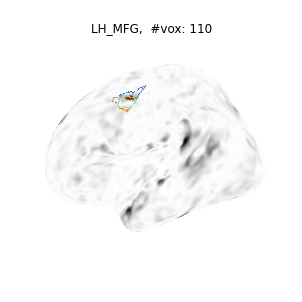

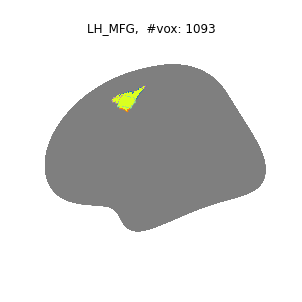

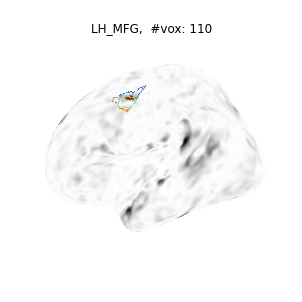

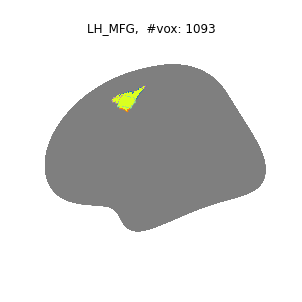

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

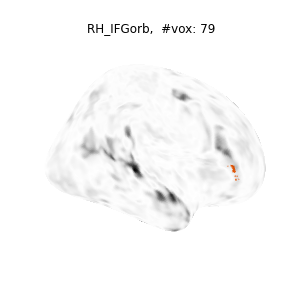

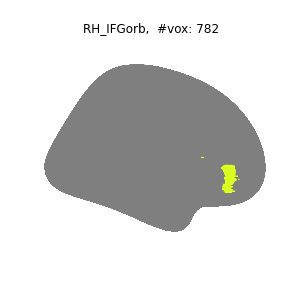

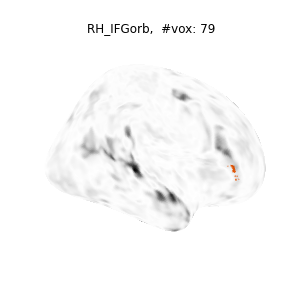

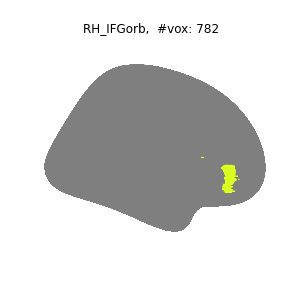

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

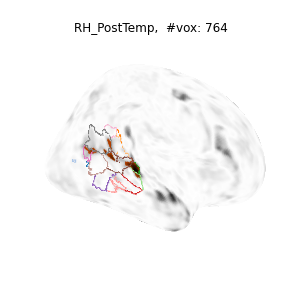

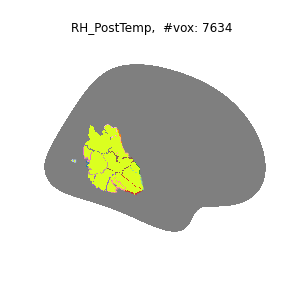

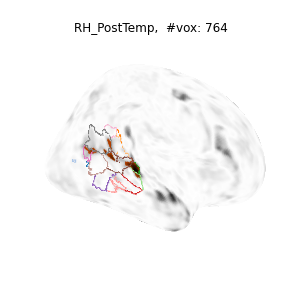

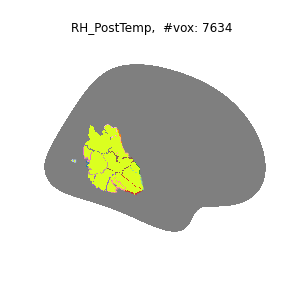

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

<Figure size 288x288 with 0 Axes>

In [19]:
# a pyplot subplots to plot histograms across ROIs and hemis
# fig_brain, ax_brain = plt.subplots(4, 6, figsize=(50, 30), subplot_kw={'projection': '3d'})

for idx, hemi in enumerate(hemis_long):
    functional_path=f'bold.fsavg.sm4.{hemis_short[idx].lower()}.lang/S-v-N'


    sub_func_dir = Path(subj_path) / subj_id / 'bold' / functional_path / ('fsig'+'.nii.gz')
    sub_dti_dir = os.path.join(subj_path, 'DTI', subj_id, functional_path)

    network_img = nib.load(sub_func_dir)
    network = np.asarray(network_img.dataobj).flatten()
    sub_parcel_roi_vxl = np.zeros(network.shape).astype(int)
    sub_parcel_roi = np.zeros(network.shape).astype(int)

    all_glasser_regions = np.zeros(network.shape).astype(int)

    # plot surface data
    # create an annotation file from the activation masks
    for ix_roi, ROI_name in enumerate(tqdm(d_parcel_name_map[network_id].values(), desc='iter over ROIs')):
        # if 'PostTemp' not in ROI_name: continue
        if hemis_[idx] not in ROI_name: continue

        roi_surf = d_parcel_fsaverage[network_id][ROI_name]
        glasser_regions = lang_rois_to_glasser_contours[ROI_name]

        all_glasser_regions |= glasser_regions
        
        samples = network[(roi_surf == 1) & ~(np.isnan(network))]
        samples_90 = np.percentile(samples, int(threshold))

        roi_voxels = ((roi_surf == 1)) & (network >= samples_90)
        print(f'ROI name: {ROI_name}, number of voxels {np.sum(roi_voxels)}')

        # do some prep work to plot the glasser contours on each of our plots
        uniques = np.unique([x for x in glasser_regions if x != 0])
        glasser_region_names = []
        colors = []
        for glasser_label in uniques:
            glasser_region_names += [glasser_info[glasser_info['regionID'] == glasser_label]['regionLongName'].iloc[0].strip()]

        def plot_glasser_contours_on_fig(fig, axes=None, legend=True):
            return plotting.plot_surf_contours(fsaverage['infl_' + hemi], glasser_regions, levels=list(uniques), 
                                               figure=fig, axes=axes, legend=legend, #colors=colors,
                                               labels=glasser_region_names)                

        # a hack to get around poor legend positioning: we plot twice, once with the legend and once without.
        for legend in [True, False]:
            
            # first, plot the glasser contours on top of the activation in the lang ROIs
            try:
                figure_act = plotting.plot_surf_roi(surf_mesh=fsaverage['infl_' + hemi], roi_map=roi_voxels,
                                            hemi=hemi, view='lateral', cmap='hot', #axes=ax_brain[idx*2, ix_roi%6],
                                            bg_map=network, bg_on_data=True, alpha=.3, #figure=fig_brain,
                                            title=f'{ROI_name},  #vox: {np.sum(roi_voxels)}',
                                            legend=legend,
                                            darkness=1)
                _ = plot_glasser_contours_on_fig(figure_act, legend=legend)
                # figure_act.savefig(f'{sub_dti_dir}/{subj_id}_{""}{ROI_name}_roi_fsig_{threshold}_fsavg_glasser_overlay_legend={legend}.png', 
                #                 facecolor=(.7,.7,.7), edgecolor='none', bbox_inches='tight')
                figure_act.clf()
            except ValueError as e:
                if "Vertices in parcellation do not form region" in repr(e):
                    print(f'{ROI_name} activations', e)
                    pass
                else:
                    raise
            
            try:
                # next, plot the glasser contours on top of the actual ROI 
                figure_roi = plotting.plot_surf_roi(surf_mesh=fsaverage['infl_' + hemi], roi_map=roi_surf,
                                                hemi=hemi, view='lateral', #axes=ax_brain[idx*2+1, ix_roi%6],
                                                bg_map=None, bg_on_data=False, alpha=.3, #figure=fig_brain,
                                                colors=['k', ], 
                                                title=f'{ROI_name},  #vox: {np.sum(roi_surf)}',
                                                legend=legend,
                                                darkness=1)
                _ = plot_glasser_contours_on_fig(figure_roi, legend=legend)
                # figure_roi.savefig(f'{sub_dti_dir}/{subj_id}_{""}{ROI_name}_roi_parcel_fsavg_glasser_overlay_legend={legend}.png', 
                #                 facecolor=(.7,.7,.7), edgecolor='none', bbox_inches='tight')
                figure_roi.clf()
            except ValueError as e:
                if "Vertices in parcellation do not form region" in repr(e):
                    print(f'{ROI_name} ROI', e)
                    pass
                else:
                    raise

    try:
        # plot full glasser regions map map
        figure = plotting.plot_surf_roi(surf_mesh=fsaverage['infl_' + hemi], roi_map=all_glasser_regions,
                                        hemi=hemi, view='lateral', cmap='hot',
                                        bg_map=network, bg_on_data=False, alpha=.3,
                                        title=f'all glasser regions in {hemi}',
                                        darkness=1)
        # figure.savefig(f'{sub_dti_dir}/{subj_id}all_{network_id}_{hemi}_roi_fsavg_glasser_overlay.png', 
        #                     facecolor=(.7,.7,.7), edgecolor='none', bbox_inches='tight')
        figure.clf()
    except ValueError as e:
        if "Vertices in parcellation do not form region" in repr(e):
            print(f'{ROI_name} just glasser contours', e)
            pass
        else:
            raise

    #     break
    # break

plotting.show()

In [3]:
# To check if there are any differences between the glasser lang regions and ROIs (since they seem identical in the figures)
for idx, hemi in enumerate(hemis_long):
    functional_path=f'bold.fsavg.sm4.{hemis_short[idx].lower()}.lang/S-v-N'
    sub_func_dir = Path(subj_path) / subj_id / 'bold' / functional_path / ('fsig'+'.nii.gz')
    sub_dti_dir = os.path.join(subj_path, 'DTI', subj_id, functional_path)
    network_img = nib.load(sub_func_dir)
    network = np.asarray(network_img.dataobj).flatten()
    sub_parcel_roi_vxl = np.zeros(network.shape).astype(int)
    sub_parcel_roi = np.zeros(network.shape).astype(int)
    all_glasser_regions = np.zeros(network.shape).astype(int)
    # to get all the glasser regions for an ROI 
    for ix_roi, ROI_name in enumerate(tqdm(d_parcel_name_map[network_id].values(), desc='iter over ROIs')):
        # if 'PostTemp' not in ROI_name: continue
        if hemis_[idx] not in ROI_name: continue
        roi_surf = d_parcel_fsaverage[network_id][ROI_name]
        glasser_regions = lang_rois_to_glasser_contours[ROI_name]
        all_glasser_regions |= glasser_regions
        print(ROI_name)
        # now to compare the full glasser ROI with the lang parcel ROI
        num_not_equal = np.size(np.where(glasser_regions!=roi_surf))
        print("num indices not equal: " + str(num_not_equal))
        num_equal = np.size(np.where(glasser_regions==roi_surf))
        print("num indices equal: " + str(num_equal))
        
        if (num_not_equal + num_equal != np.size(glasser_regions)):
            print("Nums dont add up")

NameError: name 'hemis_long' is not defined

In [5]:
# '/mindhive/evlab/u/Shared/SUBJECTS_FS/FS/sub190/'

network_img = nib.load('/om/user/ehoseini/dti_language/glasser_to_native/lh.HCP-MMP1.annot')
network = np.asarray(network_img.dataobj).flatten()
print(network.shape)

ImageFileError: Cannot work out file type of "/om/user/ehoseini/dti_language/glasser_to_native/lh.HCP-MMP1.annot"